# Heart Attack Prediction using Machine Learning Algorithms

In [8]:
!nvidia-smi

Sun May 21 18:50:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Here, I have attempted prediction using several algorithms, including:

1. Logistic Regression
2. Support Vector Machines (SVM)
3. Decision Trees
4. Random Forest
5. XGBoost

In [16]:
# import streamlit as st
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import precision_recall_fscore_support as score, mean_squared_error, confusion_matrix, roc_curve, auc
from sklearn.metrics import confusion_matrix,accuracy_score, mean_squared_error, f1_score, recall_score, precision_score, mutual_info_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

Setting certain parameters

In [9]:
# st. set_page_config(layout="wide", page_icon=":hospital:")
# st.set_option('deprecation.showPyplotGlobalUse', False)
plt.style.use('fivethirtyeight')
plt.style.use('dark_background')

Data Ingestion

In [10]:
data=pd.read_csv("https://raw.githubusercontent.com/advikmaniar/ML-Healthcare-Web-App/main/Data/heart.csv")

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


Output Value counts: 1    165
0    138
Name: output, dtype: int64
Shape of dataset:  (303, 14)
Number of classes:  2


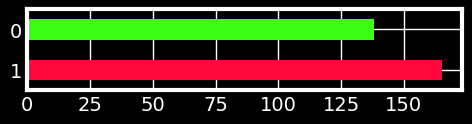

In [11]:
Y = data.output

display(data)
print("Output Value counts:", Y.value_counts())
print("Shape of dataset: ", data.shape)
print("Number of classes: ", Y.nunique())

# Calculate value counts
Y.value_counts().plot(kind='barh', figsize=(5, 1), color = ['#FF073A','#39FF14'])
plt.show()

In [12]:
data.isna().sum().sum()

0

# 1. Logistic Regression

In [17]:
def model_training(best_clf, X_train, X_test, Y_train, Y_test):
    best_clf.fit(X_train, Y_train)
    Y_pred = best_clf.predict(X_test)
    acc = accuracy_score(Y_test, Y_pred)
    return Y_pred

def Stdscaler_train_test(data):
    X = data.drop(["output"], axis=1)
    Y = data.output
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    Std_scaler = StandardScaler()
    X_train = Std_scaler.fit_transform(X_train)
    X_test = Std_scaler.transform(X_test)
    return  X_train, X_test, Y_train, Y_test

def best_params_model(clf, param_grid, X_train, X_test, Y_train, Y_test, label = "GridSearchCV"):
    if label == "RandomizedSearchCV":
      method_search = RandomizedSearchCV(clf, param_grid, n_iter=10, cv=5, scoring='accuracy')
    else:
      method_search = GridSearchCV(clf, param_grid, scoring='accuracy', cv=5)

    method_search.fit(X_train, Y_train)
    best_params = method_search.best_params_
    print(best_params)
    best_clf = clf.set_params(**best_params)  # Set the best parameters explicitly
    print(best_clf)
    Y_pred = model_training(best_clf, X_train, X_test, Y_train, Y_test)
    return Y_pred

def Print_Evaluation_Metrics(Y_test, Y_pred, algo="classifiers"):
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    accuracy = accuracy_score(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    print("Precision:", round(precision,4))
    print("Recall:", round(recall,4))
    print("F1-Score:", round(f1,4))
    print("Accuracy:", round(accuracy*100,3), "%")
    print("Mean Squared Error:", round(mse,4))
    if algo in ['DT','RF','XG']:
        print("Information Gain:", mutual_info_score(Y_test, Y_pred))

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.1, 1.0])
    plt.ylim([-0.1, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(Y_test, Y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def PredictionVSActualPlot(Y_pred,Y_test):
    plt.figure(figsize=(10,3))
    plt.scatter(range(len(Y_pred)),Y_pred,color="yellow",lw=5,label="Predictions")
    plt.scatter(range(len(Y_test)),Y_test,color="red",label="Actual")
    plt.title("Prediction Values vs Real Values")
    plt.legend()
    plt.grid(True)

{'C': 0.01, 'solver': 'liblinear'}
LogisticRegression(C=0.01, max_iter=50, solver='liblinear')
Precision: 0.8788
Recall: 0.9062
F1-Score: 0.8923
Accuracy: 88.525 %
Mean Squared Error: 0.1148


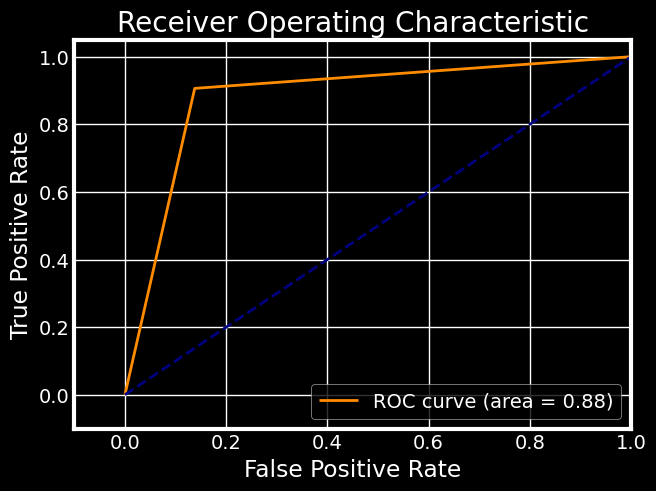

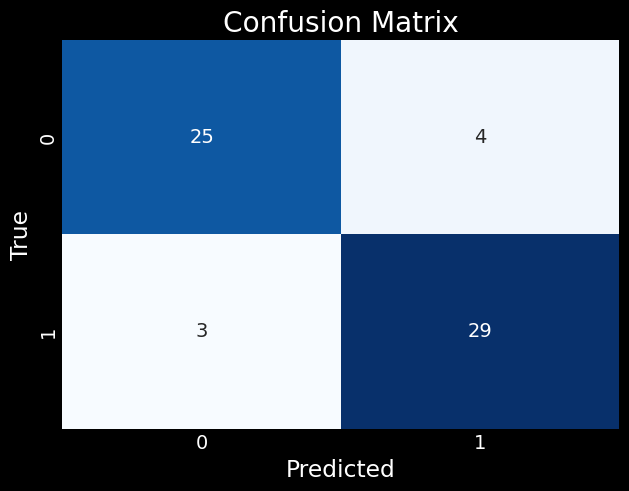

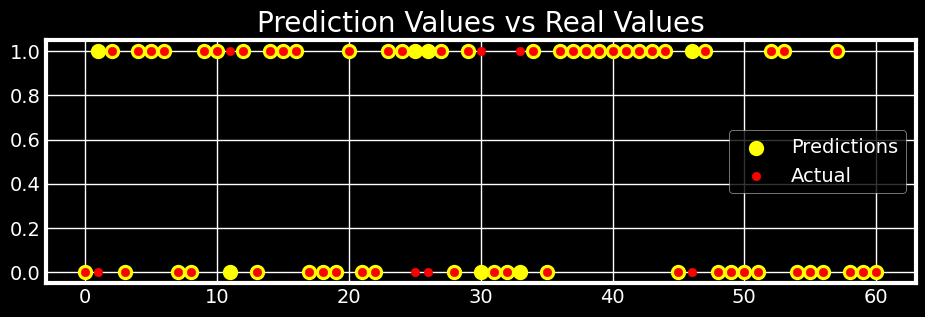

In [14]:
param_grid = {
    #'penalty' : ['l1','l2'], "C": [round(0.1 + 0.1*i, 2) for i in range(0, 16)],
    'C': np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'liblinear', 'lbfgs']
}
clf = LogisticRegression(max_iter=50, penalty='l2')
X_train, X_test, Y_train, Y_test = Stdscaler_train_test(data)
Y_pred = best_params_model(clf, param_grid, X_train, X_test, Y_train, Y_test)
Print_Evaluation_Metrics(Y_test, Y_pred)
PredictionVSActualPlot(Y_pred,Y_test)

# 2. SVM

{'C': 1.49, 'kernel': 'rbf'}
SVC(C=1.49)
Precision: 0.9
Recall: 0.8438
F1-Score: 0.871
Accuracy: 86.885 %
Mean Squared Error: 0.1311


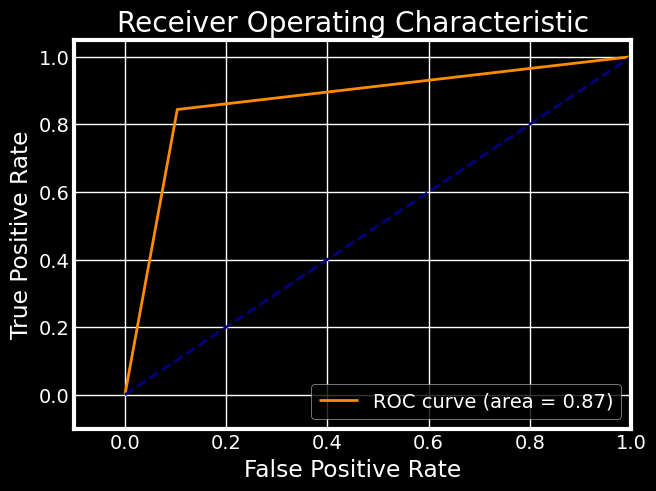

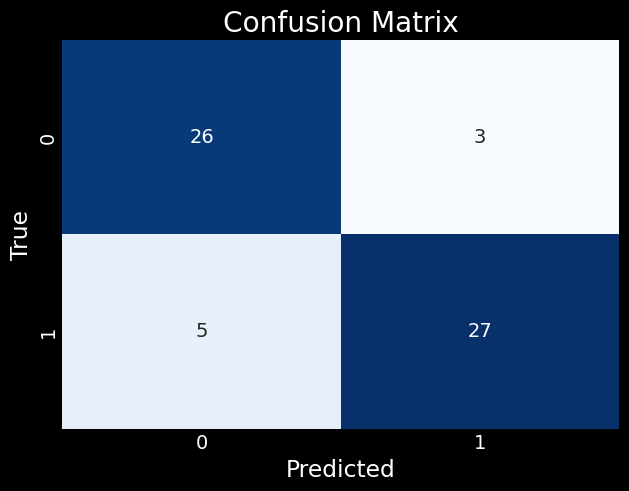

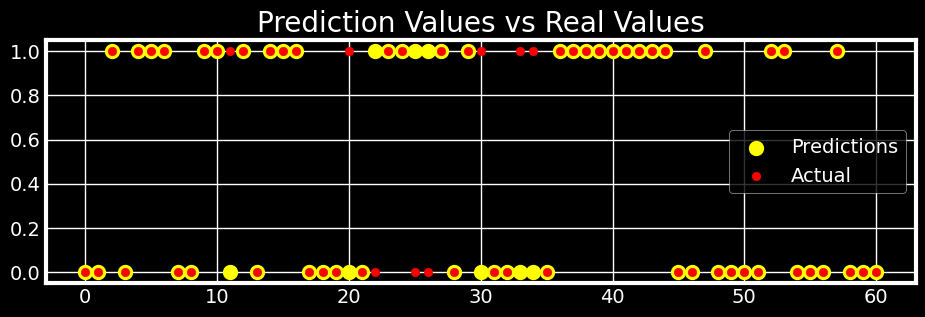

In [15]:
clf = SVC()
param_grid = {
    #'C' : np.logspace(-3,3,7),
    'C' : [round(0.01 * i, 2) for i in range(1, 1001)],
    'kernel' : ["poly","linear","sigmoid","rbf"]
}
X_train, X_test, Y_train, Y_test = Stdscaler_train_test(data)
Y_pred = best_params_model(clf, param_grid, X_train, X_test, Y_train, Y_test)
Print_Evaluation_Metrics(Y_test, Y_pred)
PredictionVSActualPlot(Y_pred,Y_test)

# 3. Decision Trees

{'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 9}
DecisionTreeClassifier(max_depth=4, min_samples_split=9)
Precision: 0.8966
Recall: 0.8125
F1-Score: 0.8525
Accuracy: 85.246 %
Mean Squared Error: 0.1475
Information Gain: 0.2806633353223562


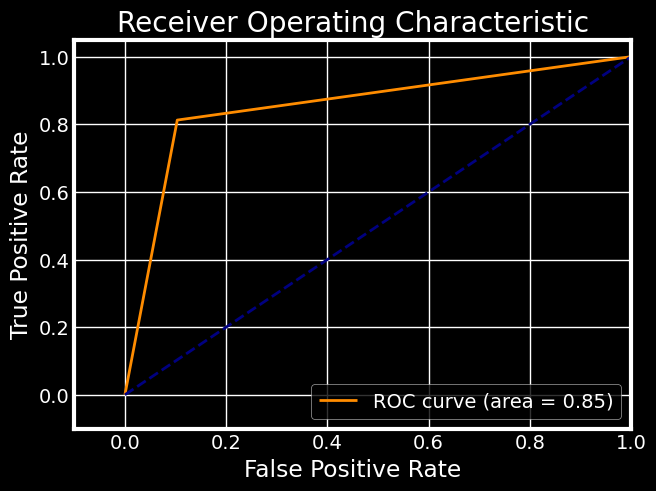

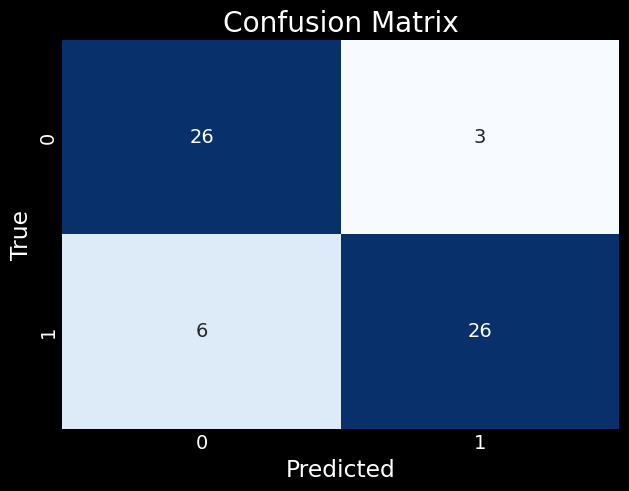

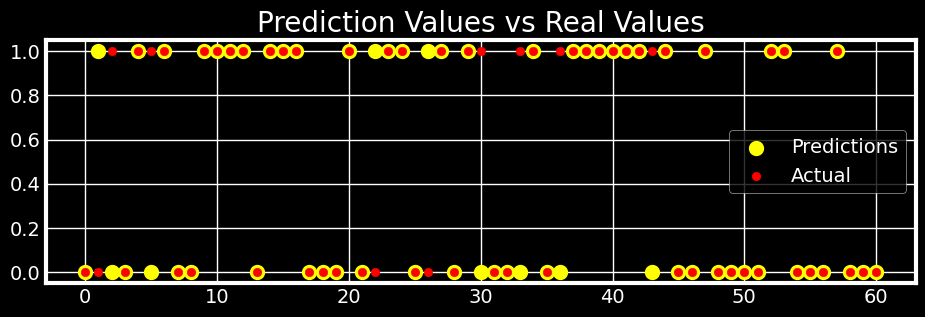

In [ ]:
clf = DecisionTreeClassifier()
param_grid = {
    'max_depth' : list(range(2, data.shape[1])),
    'criterion' : ["gini", "entropy"],
    'min_samples_split' : list(range(2, 10))
}
X_train, X_test, Y_train, Y_test = Stdscaler_train_test(data)
Y_pred = best_params_model(clf, param_grid, X_train, X_test, Y_train, Y_test)
Print_Evaluation_Metrics(Y_test, Y_pred,"DT")
PredictionVSActualPlot(Y_pred,Y_test)

# 4. Random Forest

{'criterion': 'gini', 'max_depth': 2, 'n_estimators': 20}
RandomForestClassifier(max_depth=2, n_estimators=20)
Precision: 0.9
Recall: 0.8438
F1-Score: 0.871
Accuracy: 86.885 %
Mean Squared Error: 0.1311
Information Gain: 0.307537455169165


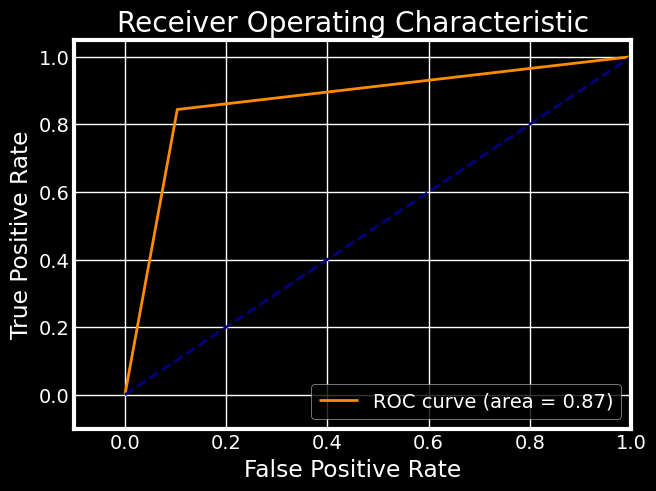

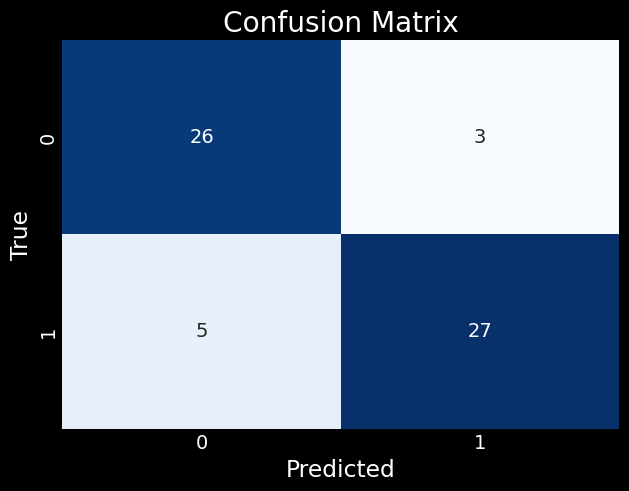

CPU times: total: 13min 39s
Wall time: 17min 1s


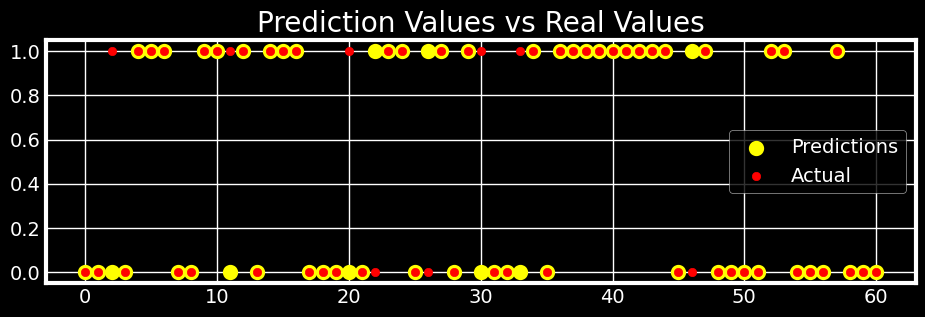

In [ ]:
%%time
clf = RandomForestClassifier()
param_grid = {
    'max_depth' : list(range(2, data.shape[1])),
    'criterion' : ["gini", "entropy"],
    'n_estimators' : list(range(20, 501, 30))
}

X_train, X_test, Y_train, Y_test = Stdscaler_train_test(data)
Y_pred = best_params_model(clf, param_grid, X_train, X_test, Y_train, Y_test)
Print_Evaluation_Metrics(Y_test, Y_pred,"RF")
PredictionVSActualPlot(Y_pred,Y_test)

# 5. XGBoost 

{'reg_lambda': 1.3, 'reg_alpha': 2.0, 'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)
Precision: 0.8788
Recall: 0.9062
F1-Score: 0.8923
Accuracy: 88.525 %
Mean Squared Error: 0.1148
Information Gain: 0.335839195801

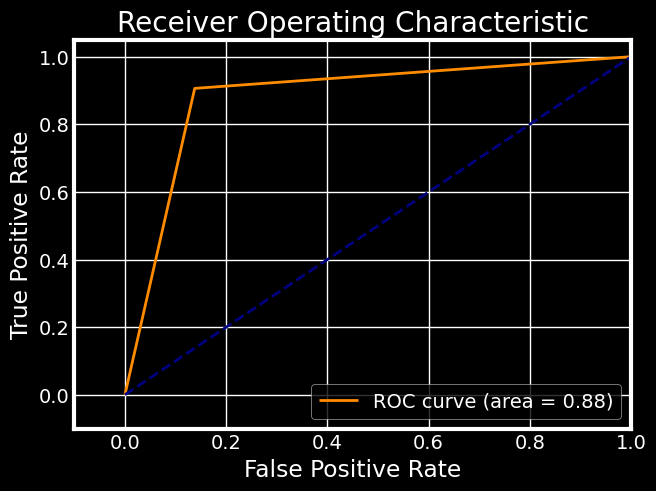

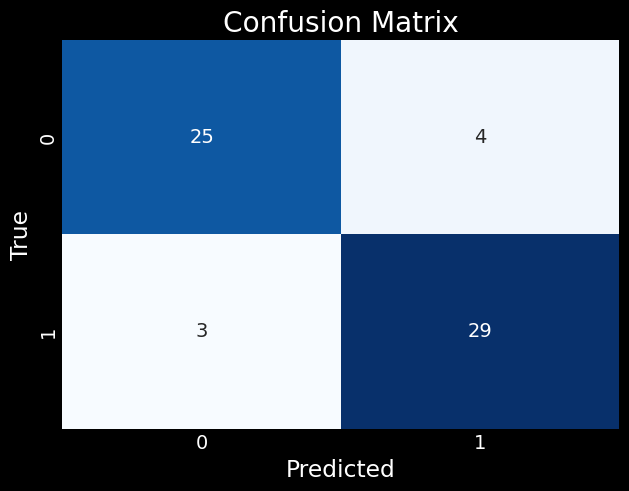

CPU times: user 14.9 s, sys: 540 ms, total: 15.4 s
Wall time: 2.57 s


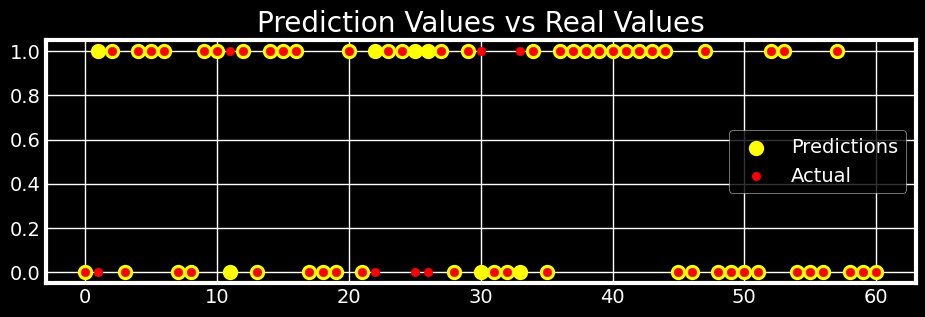

In [20]:
%%time
clf = XGBClassifier(objective = 'binary:logistic', nthread=4, seed=42)

param_grid = {
    'max_depth': range (2, 10, 1),
    'learning_rate': [0.1, 0.01, 0.05],
    'n_estimators': list(range(60, 220, 40)),
    'reg_lambda' : [i/10 for i in range(10, 51)],
    'reg_alpha' : [i/10 for i in range(0, 51)],
    'gamma' : list(range(0, 11, 5)),
    'colsample_bytree' : [i/10 for i in range(6, 10)],
}

X_train, X_test, Y_train, Y_test = Stdscaler_train_test(data)
Y_pred = best_params_model(clf, param_grid, X_train, X_test, Y_train, Y_test, "RandomizedSearchCV")
Print_Evaluation_Metrics(Y_test, Y_pred,"XG")
PredictionVSActualPlot(Y_pred,Y_test)

# PCA: Principal Component Analysis

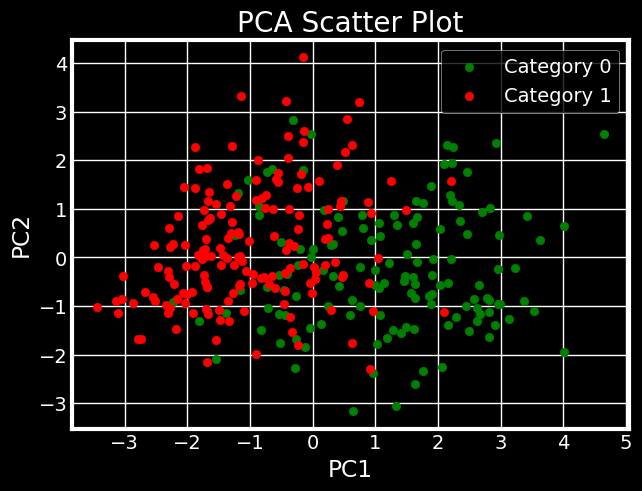

In [53]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data.iloc[:,:-1])

# Perform PCA on X_train
pca = PCA(2)  # Specify the desired number of components as 2
X_projected = pca.fit_transform(X_scaled)
x1 = X_projected[:, 0]
x2 = X_projected[:, 1]

# Check if PC1 covers at least 90% of the variance
explained_variance_ratio = pca.explained_variance_ratio_
if np.cumsum(explained_variance_ratio)[0] < 0.9:
    print("Warning: PC1 does not cover at least 90% of the variance It covers ")

# # Calculate evaluation metrics
# mse = mean_squared_error(data.iloc[:,:-1], pca.inverse_transform(X_projected))
# r2 = r2_score(data.iloc[:,:-1], pca.inverse_transform(X_projected))

# print("Explained Variance Ratio:", explained_variance_ratio)
# print("Cumulative Explained Variance Ratio:", np.cumsum(explained_variance_ratio))

plt.scatter(x1[data.iloc[:, -1] == 0], x2[data.iloc[:, -1] == 0], color='green', label='Category 0')
plt.scatter(x1[data.iloc[:, -1] == 1], x2[data.iloc[:, -1] == 1], color='red', label='Category 1')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Scatter Plot')
plt.legend()
plt.show()